<a href="https://colab.research.google.com/github/lmondada/Python-Raytracer/blob/master/Training_raytracer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(0.0, 50.0)

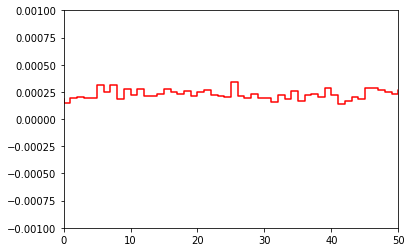

In [7]:
#theta1=1
indices=np.where(theta==1)
sample_indices= [theta[index] for index in indices]
samples_1= [x[index] for index in indices]
p_estimated_1, _ = np.histogram(samples_1, bins=4095, range=(0, 4095), density=True)

fig, ax = plt.subplots()
ax.step(range(len(p_estimated_1)), p_estimated_1,c='r', lw=1.5,label=r'$p(x|\theta_1)$')
ax.set_ylim(-0.001,0.001)
ax.set_xlim(0,50)

(0.0, 50.0)

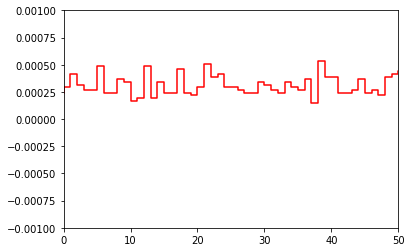

In [6]:
#theta0=2
indices0=np.where(theta==2)
sample_indices0= [theta[index] for index in indices0]
samples_0= [x[index] for index in indices0]
p_estimated_0, _ = np.histogram(samples_0, bins=4095, range=(0, 4095), density=True)

fig, ax = plt.subplots()
ax.step(range(len(p_estimated_0)), p_estimated_0,c='r', lw=1.5,label=r'$p(x|\theta_0)$')
ax.set_ylim(-0.001,0.001)
ax.set_xlim(0,50)


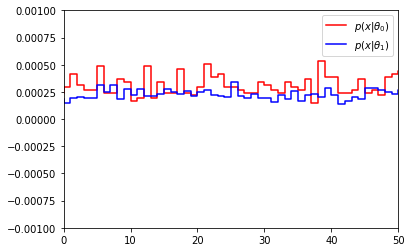

In [57]:
fig, ax = plt.subplots()
ax.step(range(len(p_estimated_0)), p_estimated_0,
         c='r', lw=1.5,
         label=r'$p(x|\theta_0)$')
ax.step(range(len(p_estimated_0)), p_estimated_1,
         c='b', lw=1.5, 
         label=r'$p(x|\theta_1)$')

ax.set_ylim(-0.001,0.001)
ax.set_xlim(0,50)
ax.legend()
plt.show()
#x-axis=x
#y-axis=p(x)

In [4]:
import numpy as np
import random
from itertools import product
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf

import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Lambda, dot, concatenate
from keras.optimizers import Adam
from keras.losses import mean_squared_error
from keras.utils import to_categorical
import pandas as pd

#loading the data

data = pd.read_csv (r'/content/all_rays_nreal3.csv')
data.columns
# Index(['pixel_index', 'color', 'purity', 'n_real', 'n_imag', 'log_p_z',
       #'log_p_z_ref', 'joint_score_p', 'joint_score_ni', 'joint_score_nr',
       #'joint_score_ref_p', 'joint_score_ref_nr', 'joint_score_ref_ni'],dtype='object')
x=data['pixel_index']
color=data['color']
purity=data['purity']
theta=data['n_real']
n_imag=data['n_imag']
log_p_z=data['log_p_z']
log_p_z_ref=data['log_p_z_ref']

#joint_score_p
js=data["joint_score_p"].apply(lambda x: format(x, 'f'))
js=js.values
joint_score=list(pd.to_numeric(js))
#joint_score_ni
js_i=data["joint_score_ni"].apply(lambda x: format(x, 'f'))
js_i=js_i.values
joint_score_ni=list(pd.to_numeric(js_i))
#joint_score_nr
js_r=data["joint_score_nr"].apply(lambda x: format(x, 'f'))
js_r=js_r.values
joint_score_nr=list(pd.to_numeric(js_r))

#joint_score_ref_p
data['joint_score_ref_p'] = data['joint_score_ref_p'].replace(np.nan, 0)
js_ref=data["joint_score_ref_p"].apply(lambda x: format(x, 'f'))
js_ref=js_ref.values
joint_score_ref_p=list(pd.to_numeric(js_ref))
#js_ref=np.where(np.isnan(js_ref), 0, js_ref)
len(joint_score_ref_p)

#joint_score_ref_ni
data['joint_score_ref_ni'] = data['joint_score_ref_ni'].replace(np.nan, 0)
js_i_ref=data["joint_score_ref_ni"].apply(lambda x: format(x, 'f'))
js_i_ref=js_i_ref.values
joint_score_ref_ni=list(pd.to_numeric(js_i_ref))
#joint_score_nr
data['joint_score_ref_nr'] = data['joint_score_ref_nr'].replace(np.nan, 0)
js_r_ref=data["joint_score_ref_nr"].apply(lambda x: format(x, 'f'))
js_r_ref=js_r_ref.values
joint_score_ref_nr=list(pd.to_numeric(js_r_ref))
#image size=64*64 so the observable range is 4096 pixels

n_positions=4096
n_nails=4095 #n_positions-1
n_features = 1 
hidden_size = 10
n_outputs = n_nails
batch_size = 16
n_epochs = 50
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

import random
def get_unique_indices(iterable, N):
  seen = set()
  for e in iterable:
        if e in seen:
            continue
        seen.add(e)
        yield e
        if len(seen) == N:
           return 
def draw(n_samples):

  all_x = []
  all_t_xz = []
  all_thetas = []
#getting the unique indices(not-repeating)
  indices=np.where(np.logical_and(theta>0.5, theta<2.2))
  indices = list(get_unique_indices(indices[0], 80000))
  rand_ind=[]
  for i in range(n_samples):
    unique=random.choice(indices)
    rand_ind.append(unique)

  all_thetas= [theta[index] for index in rand_ind]
  all_x= [x[index] for index in rand_ind]
  all_t_xz= [joint_score_nr[index] for index in rand_ind]
  all_t_xz_ref= [joint_score_nr[index] for index in rand_ind]

  all_x = np.array(all_x).reshape(-1, 1)
  all_x = to_categorical(all_x, num_classes=4095)
  all_t_xz = np.array(all_t_xz).reshape(-1, 1)
  all_thetas = np.array(all_thetas).reshape(-1, 1)
  all_t_xz_ref=np.array(all_t_xz_ref).reshape(-1,1)
  return all_x,all_thetas,all_t_xz,all_t_xz_ref

def make_nde(lr=0.001):   
    theta = Input(shape=(1,))
    h = Dense(hidden_size, activation="tanh")(theta)
    phat_theta = Dense(n_outputs, activation="softmax")(h)
    
    model = Model(inputs=[theta], outputs=[phat_theta])
    opt = Adam(lr=lr)
    model.compile(loss=["categorical_crossentropy"], optimizer=opt)
    
    return model
#SCANDAL
def make_scandal(lr=0.001):
    theta = Input(shape=(1,))
    h = Dense(hidden_size, activation="tanh")(theta)
    phat_theta = Dense(n_outputs, activation="softmax")(h)
    
    x = Input(shape=(n_outputs,))
    phat_x_theta = dot([x, phat_theta], axes=1) 
    t_x = Lambda(lambda exp: K.gradients(K.log(exp[0]), [exp[1]])[0], 
                 output_shape=(n_features,))([phat_x_theta, theta])
    
    model = Model(inputs=[theta, x], outputs=[phat_theta, t_x])
    opt = Adam(lr=lr)
    model.compile(loss=["categorical_crossentropy", "mse"], optimizer=opt)
    
    return model


In [ ]:
x,theta,t_xz,t_xz_ref = draw(30000)

print(x.shape,theta.shape,t_xz.shape)

In [ ]:
#NDE
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
nde = make_nde()
nde.fit(
    theta, x,
    batch_size=batch_size, epochs=n_epochs, verbose=1,callbacks=[callback])

In [ ]:
#SCANDAL
scandal=make_scandal()
scandal.fit(
    [theta, x],
    [x, t_xz],
    batch_size=batch_size, epochs=n_epochs, verbose=1, callbacks=[callback]
)

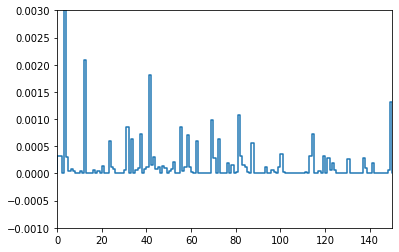

Text(3.200000000000003, 0.5, 'NDE')

In [14]:
s0=np.array(samples_0)
s0[0].shape
#predicitng
NDE_0=nde.predict(s0[0])
#NDE_0[0].shape
fig, ax = plt.subplots()
ax.step(range(4095), NDE_0[0].ravel(), label="NDE")
ax.set_ylim(-0.001,0.003)
ax.set_xlim(0,150)
plt.show()
ax.set_ylabel(r'NDE')


In [ ]:
plt.step(range(n_nails), scandal.predict(s0[0]))

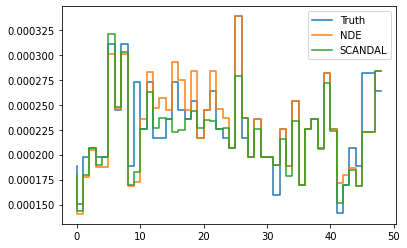

In [56]:
Truth=p_estimated_1[0:49]
plt.step(range(49), Truth, label="Truth")
plt.step(range(49), NDE, label="NDE")
plt.step(range(49), SCANDAL, label="SCANDAL")
#plt.set_ylim(0.0001,0.0010)
plt.legend()
plt.show()

In [34]:
#Drawing data for ROLR and RASCAL
def draw_ratio(n_samples):
   all_x = []
   all_log_r_xz = []
   all_t_xz_0 = []
   all_thetas = []
   grid = list(product(np.linspace(0.5,2,7), np.linspace(0.5,2,7)))
   n_traces_per_theta =  n_samples// (2 * len(grid))
  # draw from theta_0
   indices=np.where(np.logical_and(theta>0.5, theta<2.2))
   indices = list(get_unique_indices(indices[0], 80000))
   rand_ind=[]
   for i in range(n_samples):
     unique=random.choice(indices)
     rand_ind.append(unique)
    
  # x, log_p_xz_0, log_p_xz_1, t_xz_0
  
   theta_0= [theta[index] for index in rand_ind]
   all_x= [x[index] for index in rand_ind]
   all_t_xz= [joint_score_nr[index] for index in rand_ind]
   all_log_p_z= [log_p_z[index] for index in rand_ind]
   all_log_p_z_ref= [log_p_z_ref[index] for index in rand_ind]
        
  
   all_log_r_xz.append(log_p_z - log_p_z_ref)
   for i in range(len(theta_0)):
     i=theta_0[i]
     all_thetas.append(np.tile(np.array([theta_0, 1.5]), (n_traces_per_theta, 1))) #ref theta=1.5  
    # reshape
   all_x = np.array(all_x).reshape(-1, 1)
   all_x = to_categorical(all_x, num_classes=n_nails)
   all_log_r_xz = np.array(all_log_r_xz).reshape(-1, 1)
   all_t_xz_0 = np.array(all_t_xz_0).reshape(-1, 1)
   all_thetas = np.vstack(all_thetas)
   return all_x, all_thetas, all_log_r_xz, all_t_xz
#models
#ROLR and RASCAL
def make_rolr(lr=0.001):
    theta0 = Input(shape=(1,))
    theta1 = Input(shape=(1,))
    thetas = concatenate([theta0, theta1])
    
    h = Dense(hidden_size, activation="tanh")(thetas)
    log_rhat_thetas = Dense(n_outputs, activation="linear")(h)
    rhat_thetas = Lambda(lambda exp: K.exp(exp))(log_rhat_thetas)
    
    x = Input(shape=(n_outputs,))
    rhat_x_thetas = dot([x, rhat_thetas], axes=1)
    
    model = Model(inputs=[theta0, theta1, x], outputs=[rhat_x_thetas])
    opt = Adam(lr=lr)
    model.compile(loss=[inv_mse], optimizer=opt)
    
    return model


def inv_mse(y_true, y_pred):
    inverse_r_loss = mean_squared_error((1./ K.clip(y_true, -10., 10.)),
                                               (1./ K.clip(y_pred, -10., 10.)))

    return inverse_r_loss


def make_rascal(lr=0.001):
    theta0 = Input(shape=(1,))
    theta1 = Input(shape=(1,))
    thetas = concatenate([theta0, theta1])
    
    h = Dense(hidden_size, activation="tanh")(thetas)
    log_rhat_thetas = Dense(n_outputs, activation="linear")(h)
    rhat_thetas = Lambda(lambda exp: K.exp(exp))(log_rhat_thetas)
    
    x = Input(shape=(n_outputs,))
    rhat_x_thetas = dot([x, rhat_thetas], axes=1)
    
    log_rhat_x_theta = dot([x, log_rhat_thetas], axes=1) 
    t_x_0 = Lambda(lambda exp: K.gradients(exp[0], [exp[1]])[0], 
                   output_shape=(n_features,))([log_rhat_x_theta, theta0])
    
    model = Model(inputs=[theta0, theta1, x], outputs=[rhat_x_thetas, t_x_0])
    opt = Adam(lr=lr)
    model.compile(loss=[inv_mse, "mse"], loss_weights=[1.0, 0.5], optimizer=opt)
    
    return model

In [ ]:
all_x, all_thetas, all_log_r_xz, all_t_xz=draw_ratio(1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
rascal = make_rascal()
rascal.fit(
    [all_thetas[:, 0], all_thetas[:, 1], x], 
    [np.exp(all_log_r_xz), all_t_xz], 
    batch_size=batch_size, epochs=n_epochs, verbose=0
)

In [ ]:
rolr = make_rolr()
rolr.fit(
    [all_thetas[:, 0], all_thetas[:, 1], x], 
    np.exp(all_log_r_xz),
    batch_size=batch_size, epochs=n_epochs, verbose=0
)

In [ ]:
#Comparison
def compute_mse(p_train, p_estimated):
    p_ratio_train =  np.log(p_train[0]) - np.log(p_train[1])
    p_ratio = np.log(p_estimated[0]) - np.log(p_estimated[1])
    mse = p_ratio_train - p_ratio
    mse[np.logical_or(np.isinf(mse),np.isnan(mse))] = 0.
    mse = np.dot(mse ** 2, p_estimated[1])
    
    return mse


def compute_mse_ratio(ratio, p_estimated, log=True):
    p_ratio = np.log(p_estimated[0]) - np.log(p_estimated[1])
    
    if log:
        p_ratio_train = np.log(ratio)
    else:
        p_ratio_train = ratio
        
    mse = p_ratio_train - p_ratio
    mse[np.logical_or(np.isinf(mse),np.isnan(mse))] = 0.
    mse = np.dot(mse ** 2, p_estimated[1])
    
    return mse

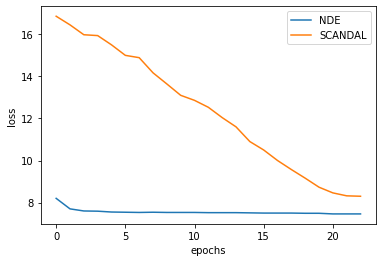

AttributeError: ignored

In [23]:
#losses gathered separately
from matplotlib import pyplot as plt
SCANDAL=[16.86,16.45,15.98,15.94,15.5,15.0,14.89,14.17,13.64,13.1,12.86,12.53,12.04,11.6,10.90,10.5,10.0,9.57,9.16,8.73,8.46,8.32,8.30]
NDE=[8.2,7.7,7.6,7.59,7.55,7.54,7.53,7.54,7.53,7.53,7.53,7.52,7.52,7.52,7.51,7.50,7.50,7.50,7.49,7.49,7.46,7.46,7.46]
n=range(23)
# plotting the NDE and SCANDAL
plt.plot(n, NDE, label = "NDE")
plt.plot(n, SCANDAL, label = "SCANDAL")
plt.xlabel('epochs')
# Set the y axis label of the current axis.
plt.ylabel('loss')
plt.legend()
# Display a figure.
plt.show()
plt.set_ylim(0,10)
plt.set_xlim(0,35)
